In [1]:
import numpy as np
import meds

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

sns.set()

In [3]:
tilename = "DES0124-3332"
pizza_name = "/Users/beckermr/Downloads/DES0124-3332_r5191p01_r_pizza-cutter-slices.fits.fz"
stamp_name = "/Users/beckermr/Downloads/DES0124-3332_r4907p01_r_meds-Y6A1.fits.fz"
m = meds.MEDS(pizza_name)
mobj = meds.MEDS(stamp_name)

In [4]:
print(m._fits.hdu_map["metadata"].read()["config"][0])

des_data:
  campaign: Y6A2_COADD
  source_type: finalcut

# optional but these are good defaults
fpack_pars:
  FZQVALUE: 4
  FZTILE: "(10240,1)"
  FZALGOR: "RICE_1"
  # preserve zeros, don't dither them
  FZQMETHD: "SUBTRACTIVE_DITHER_2"

coadd:
  # these are in pixels
  # the total "pizza slice" will be central_size + 2 * buffer_size
  central_size: 100  # size of the central region
  buffer_size: 50  # size of the buffer on each size

  # this should be odd and bigger than any stamp returned by the
  # PSF reconstruction
  psf_box_size: 51

  wcs_type: image
  coadding_weight: 'noise'

single_epoch:
  # set this to either piff or psfex
  # if using piff in DES and a release earlier than Y6,
  # you need to set the piff_run above too
  psf_type: piff

  # which SE WCS to use - one of piff, pixmappy or image
  wcs_type: pixmappy

  reject_outliers: False
  symmetrize_masking: True
  max_masked_fraction: 0.1
  max_unmasked_trail_fraction: 0.02
  edge_buffer: 64

  # Y6 already deals wit

<IPython.core.display.Javascript object>


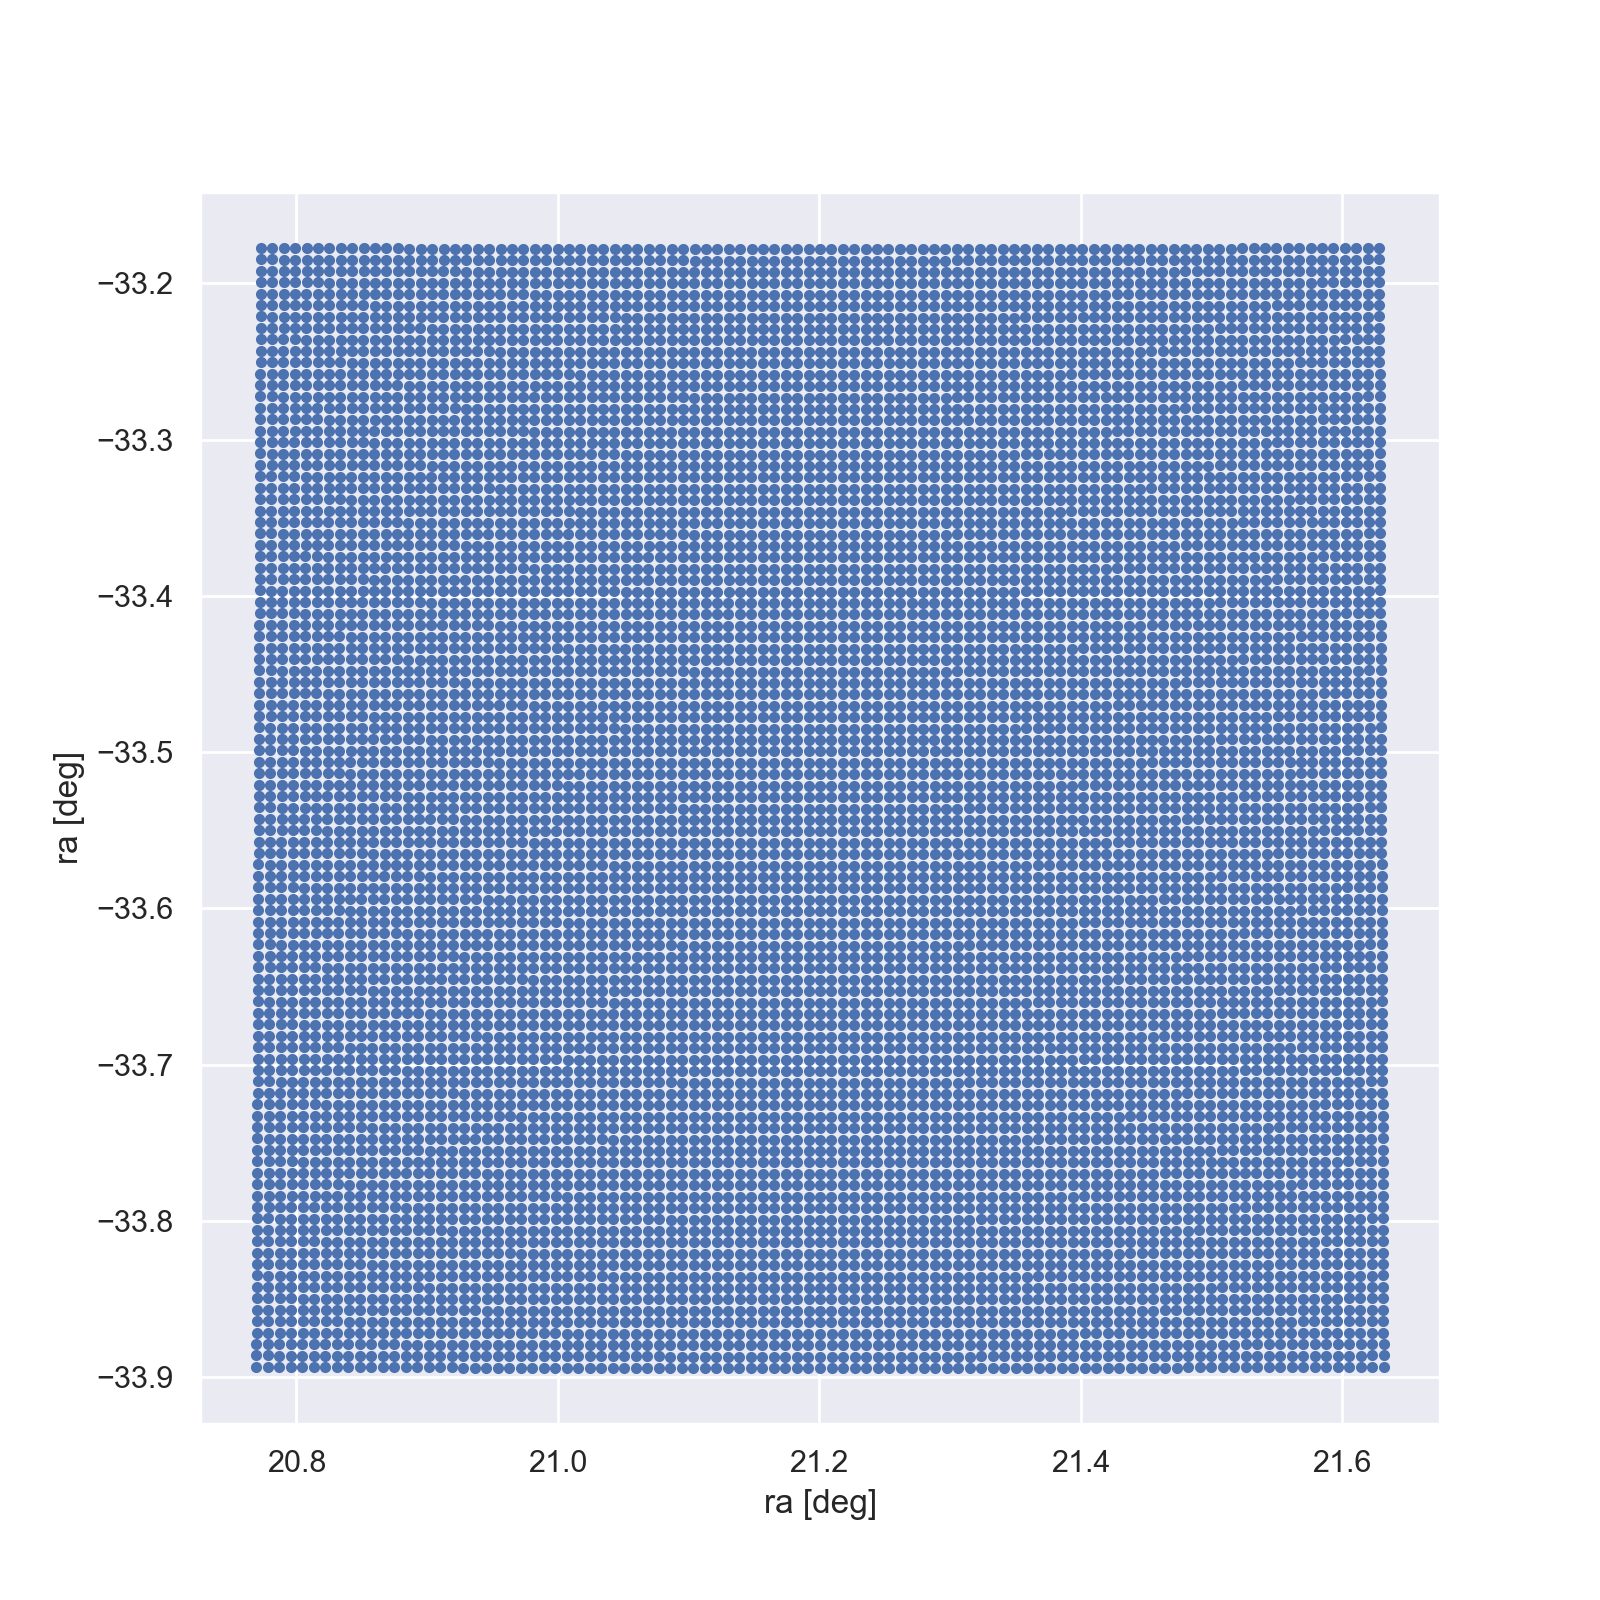

Text(0, 0.5, 'ra [deg]')

In [7]:
plt.figure(figsize=(8, 8))

q = np.where(m['ra'] > 180.0)
m['ra'][q] = m['ra'][q] - 360.0

plt.plot(m['ra'], m['dec'], '.')
plt.xlabel('ra [deg]')
plt.ylabel('ra [deg]')

<IPython.core.display.Javascript object>


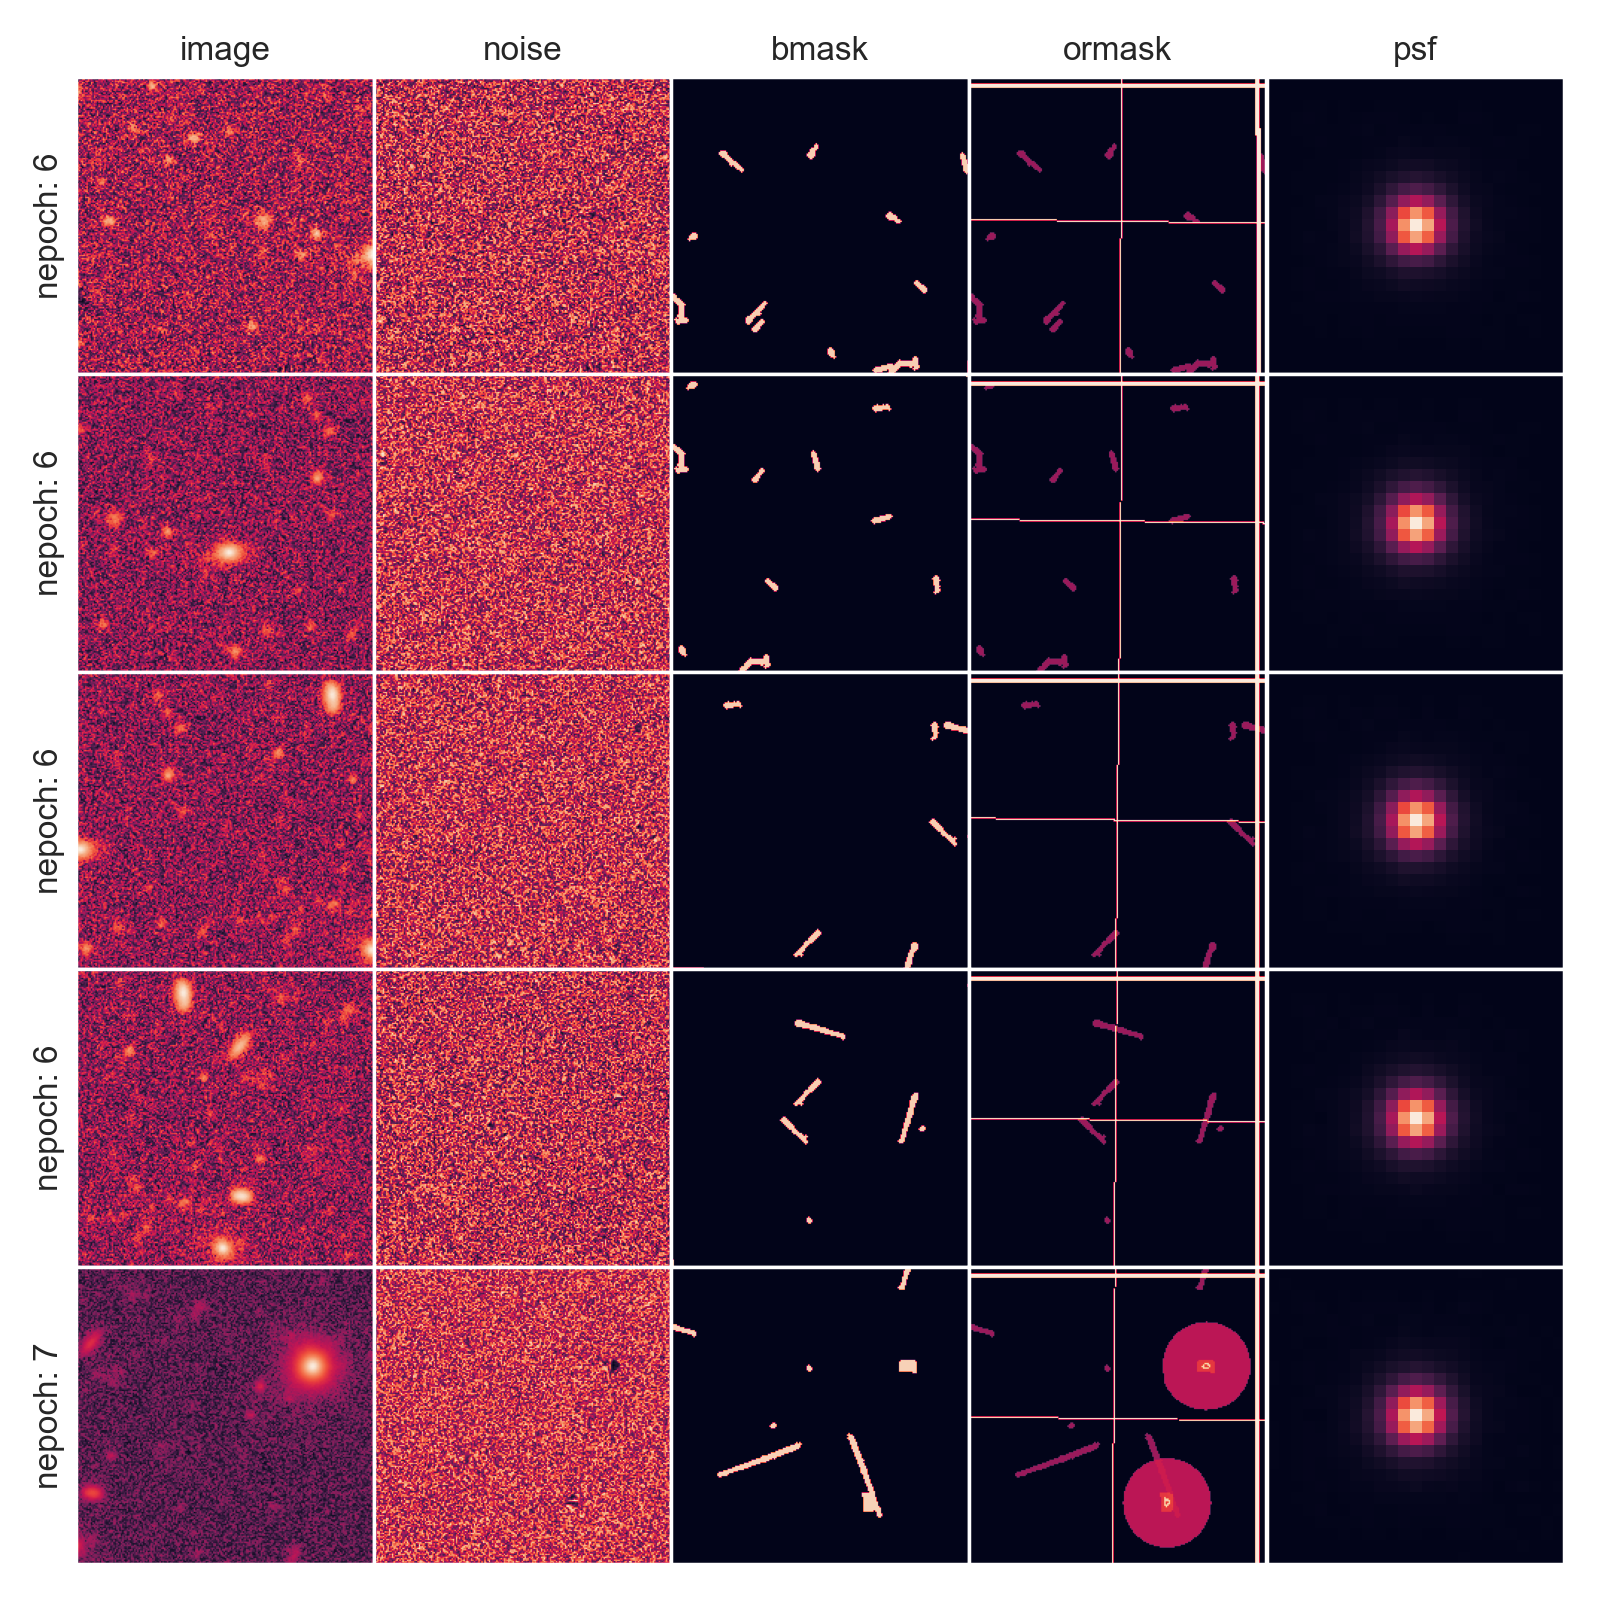

In [8]:
istart = 2000
ncut = 5
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8, 8), sharex='col', sharey='col')
# typ = 'image' # 'weight', 'seg', 'bmask', 'ormask', 'noise' or 'psf'.

psfs = []
for i, ind in enumerate(range(istart, istart+ncut)):
    for j, typ in enumerate(["image", "noise", "bmask", "ormask", "psf"]):
        ax = axs[i, j]
        im = m.get_cutout(ind, 0, type=typ)
        if typ == "psf":
            im = im[13:-13, 13:-13]

        ax.imshow(np.arcsinh(im))
        ax.grid(False)
        ax.xaxis.set_visible(False)
        if typ == "psf":
            psfs.append(im)
            
        if typ == "image":
            ax.set_ylabel("nepoch: %d" % m["nepoch"][ind])
            ax.set_yticks([])
        else:
            ax.yaxis.set_visible(False)

        if i == 0:
            ax.set_title(typ)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("pizza.png")

<IPython.core.display.Javascript object>


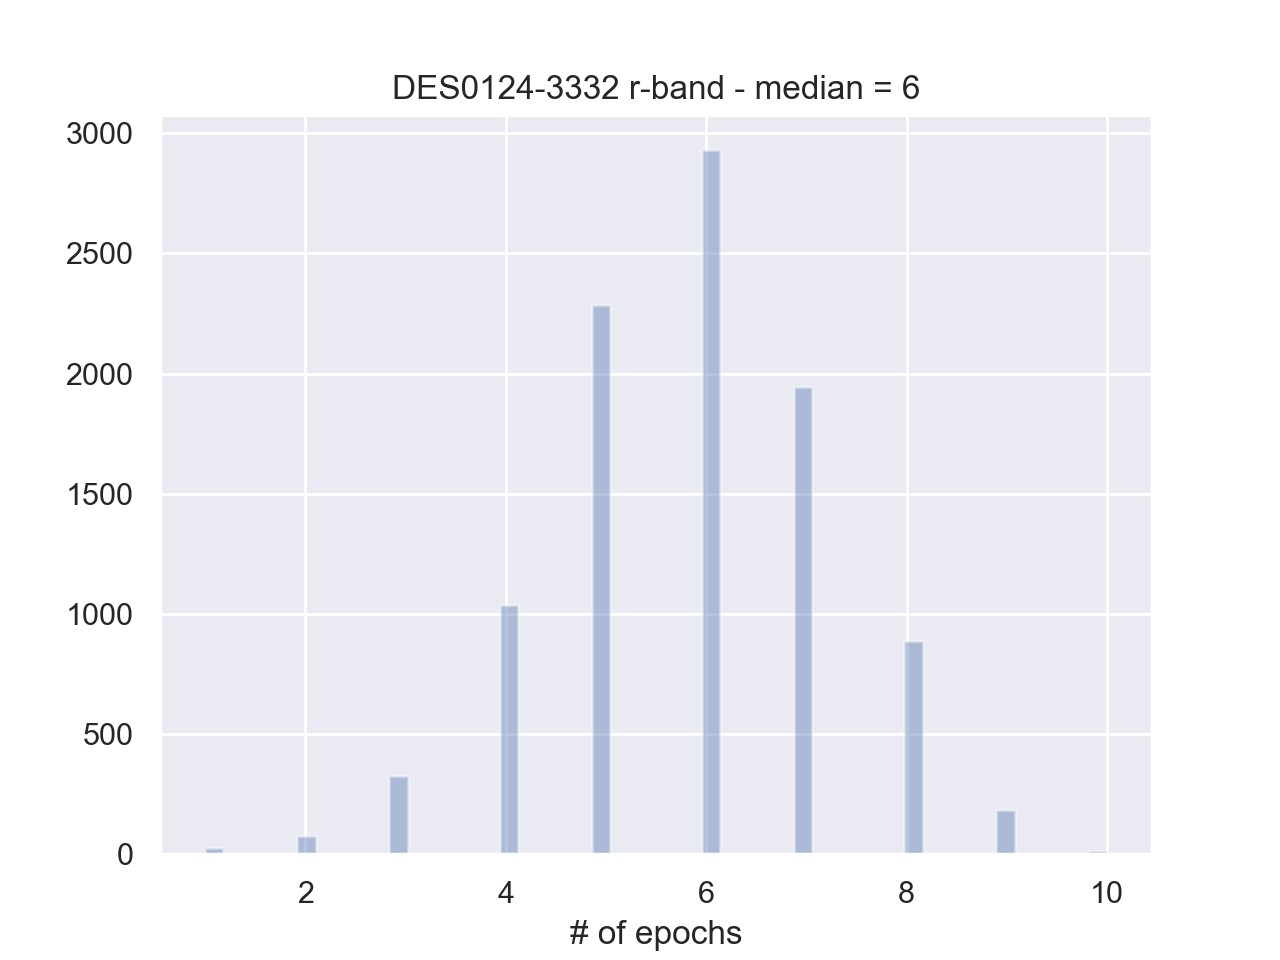

/Users/beckermr/miniconda3/envs/desy6/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [9]:
plt.figure()

msk = m["nepoch"] > 0
sns.distplot(np.array(m["nepoch"][msk], dtype="<f8"), kde=False)
ax = plt.gca()
ax.set_xlabel("# of epochs")
ax.set_title("%s r-band - median = %d" % (tilename, np.median(m["nepoch"][msk])))
plt.savefig("nepochs.png")

## go object by object

In [10]:
def _convert_to_index(row, col, dbox=100, edge=50):
    xind = (col.astype(int) - edge)//dbox
    yind = (row.astype(int) - edge)//dbox
    return xind + 99*yind

assert np.array_equal(_convert_to_index(m["orig_row"][:, 0], m["orig_col"][:, 0]), np.arange(len(m["orig_col"][:, 0]), dtype=int))

In [11]:
pizza_inds = _convert_to_index(mobj["orig_row"][:, 0], mobj["orig_col"][:, 0])

In [12]:
from meds.defaults import BMASK_EDGE
import tqdm

dnepoch = []
nepoch = []
for obj_ind, pizza_ind in tqdm.tqdm(enumerate(pizza_inds), total=len(pizza_inds)):
    if pizza_ind < 0 or pizza_ind >= 1521 or m["nepoch"][pizza_ind] <= 0:
        continue
    
    nepoch_obj = 0
    for msk_ind in range(1, mobj["ncutout"][obj_ind]):
        msk = mobj.get_cutout(obj_ind, msk_ind, type="bmask")
        if not np.any(msk & BMASK_EDGE):
            nepoch_obj += 1
    dnepoch.append(m["nepoch"][pizza_ind] - nepoch_obj)
    nepoch.append(nepoch_obj)

100%|██████████| 65306/65306 [00:05<00:00, 11215.38it/s] 


<IPython.core.display.Javascript object>


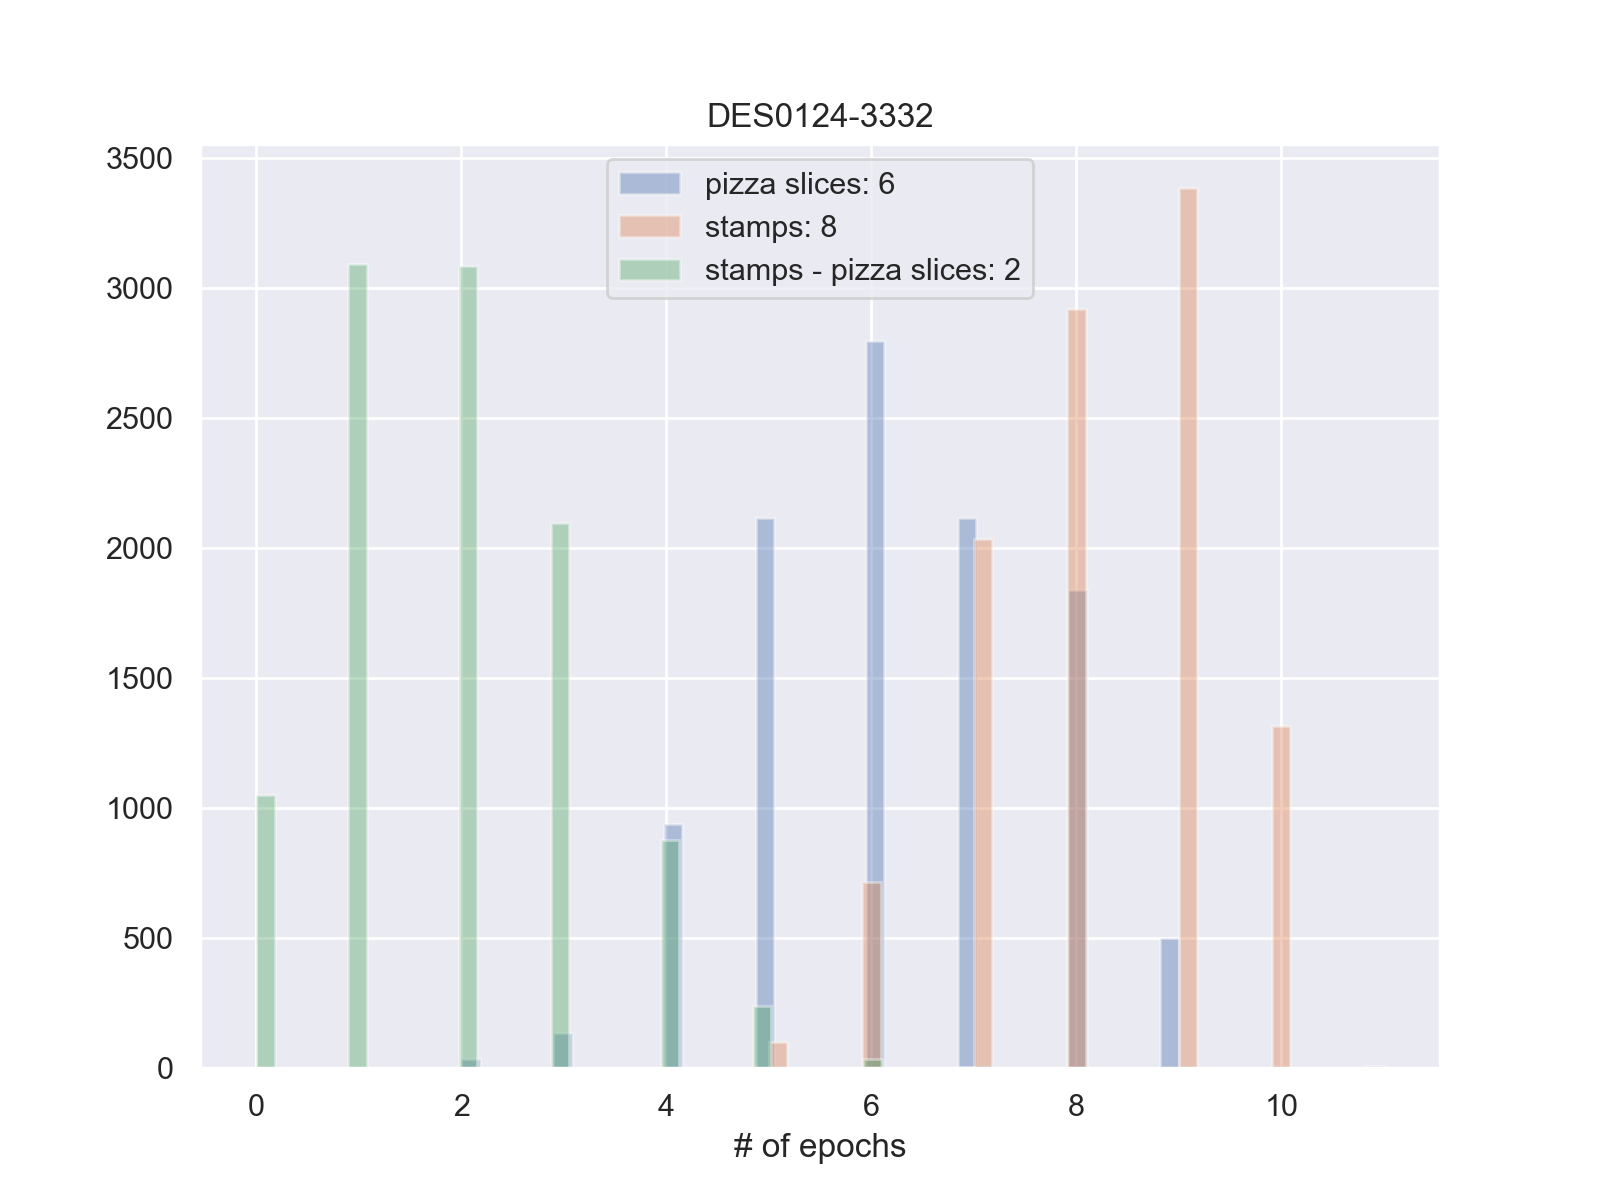

Text(0.5, 1.0, 'DES0124-3332')

In [20]:
plt.figure(figsize=(8, 6))
sns.distplot(
    np.array(dnepoch) + np.array(nepoch), 
    kde=False, 
    label="pizza slices: %d" % np.median(np.array(dnepoch) + np.array(nepoch))
)
sns.distplot(
    nepoch, 
    kde=False, 
    label="stamps: %d" % np.median(nepoch)
)
sns.distplot(
    -np.array(dnepoch), 
    kde=False, 
    label="stamps - pizza slices: %d" % (-np.median(dnepoch))
)

plt.legend()
plt.xlabel("# of epochs")
plt.savefig("ouch.png")
plt.title(tilename)